In [1]:
using CMBLensing, PythonPlot


┌ Error: LLVM extensions library unavailable for your platform:
│   aarch64-apple-darwin-libgfortran5-cxx11-llvm_version+18-julia_version+1.12.1
│ LLVM.jl will not be functional.
│ 
│ If you are using a custom version of LLVM, try building a
│ custom version of LLVMExtra_jll using `deps/build_local.jl`
└ @ LLVM ~/.julia/packages/LLVM/bzSzE/src/LLVM.jl:103


MAPEestimation

In [2]:
Cℓ = camb(r=0.05);

In [3]:
Cℓn = noiseCℓs(μKarcminT=1, ℓknee=100);

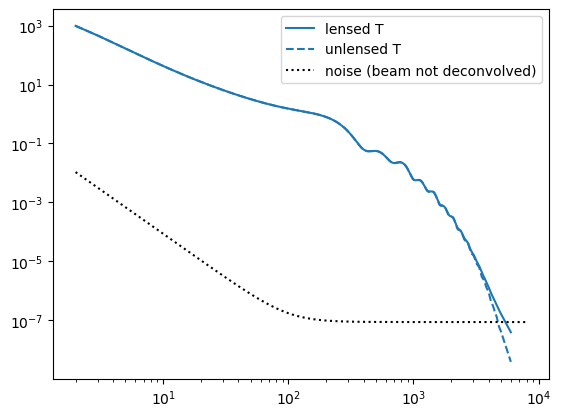

In [4]:
loglog(Cℓ.total.TT,c="C0")
loglog(Cℓ.unlensed_total.TT,"--",c="C0")
loglog(Cℓn.TT,"k:")
legend(["lensed T","unlensed T", "noise (beam not deconvolved)"]);

In [5]:
θpix  = 3        # pixel size in arcmin
Nside = 128      # number of pixels per side in the map
pol   = :I       # type of data to use (can be :T, :P, or :TP)
T     = Float32  # data type (Float32 is ~2 as fast as Float64);
bandpass_mask = LowPass(10000);

In [6]:
(;f, f̃, ϕ, ds) = load_sim(
    seed = 3,
    Cℓ = Cℓ,
    Cℓn = Cℓn,
    θpix = θpix,
    T = T,
    Nside = Nside,
    pol = pol,
    L = LenseFlow(10),
    bandpass_mask=bandpass_mask
)

(;Cf, Cϕ) = ds;

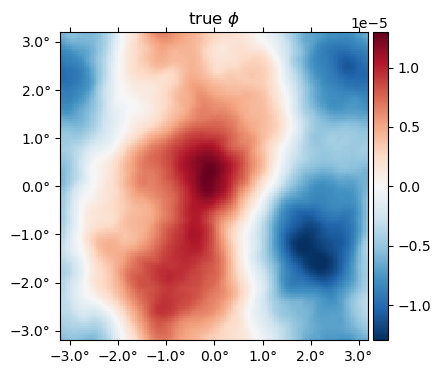

In [7]:
PythonPlot.plot(ϕ, title = raw"true $\phi$");


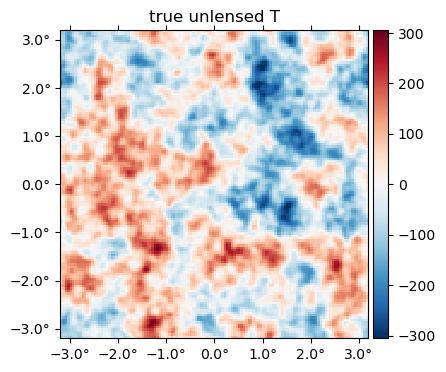

In [8]:
PythonPlot.plot(f, title = "true unlensed " .* ["T"]);

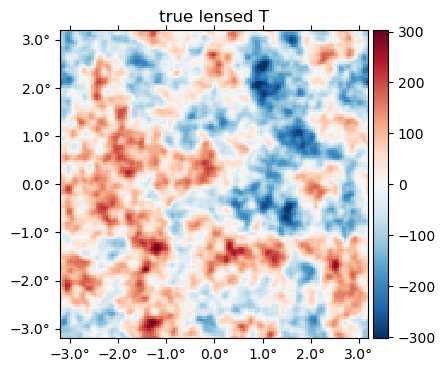

In [9]:
PythonPlot.plot(LenseFlow(ϕ)*f, title = "true lensed " .* ["T"]);

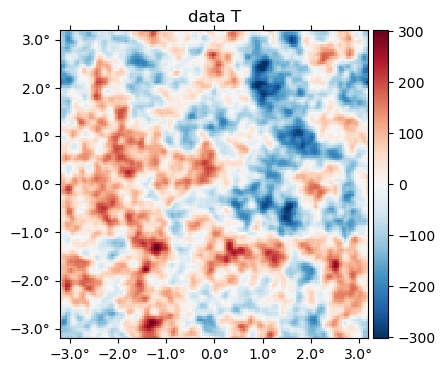

In [10]:
PythonPlot.plot(ds.d, title = "data " .* ["T"]);

In [11]:
fJ, ϕJ, hist = MAP_joint(ds, nsteps=30, progress=true);



MAP_joint: 100%|████████████████████████████████████████| Time: 0:02:20
         step: 30
       logpdf: 273205.72
            α: 0.09252058
     ΔΩ°_norm: 8.8e-05
           CG: 16 iterations (1.51 sec)
   Linesearch: 13 bisections (1.81 sec)


<sys>:0: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


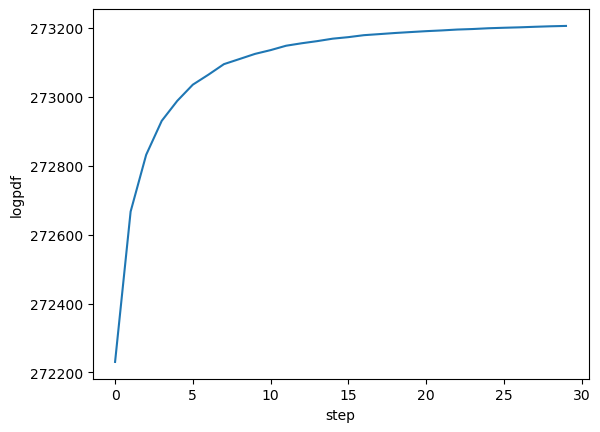

In [12]:
PythonPlot.plot(getindex.(hist, :logpdf))
xlabel("step")
ylabel("logpdf");
PythonPlot.show()

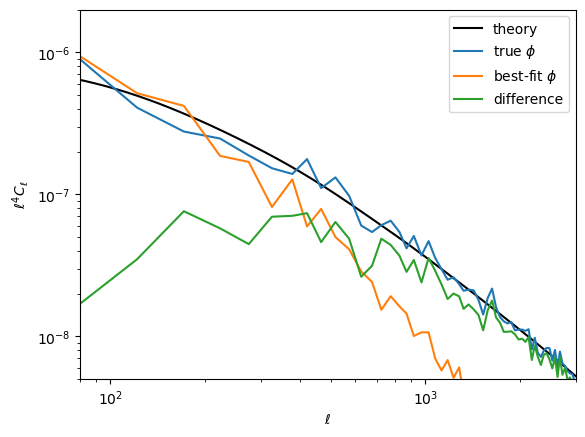

In [13]:
loglog(ℓ⁴ * Cℓ.total.ϕϕ, "k")
loglog(get_ℓ⁴Cℓ(ϕ))
loglog(get_ℓ⁴Cℓ(ϕJ))
loglog(get_ℓ⁴Cℓ(ϕJ-ϕ))
xlim(80,3000)
ylim(5e-9,2e-6)
legend(["theory",raw"true $\phi$", raw"best-fit $\phi$", "difference"])
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell$");
PythonPlot.show()

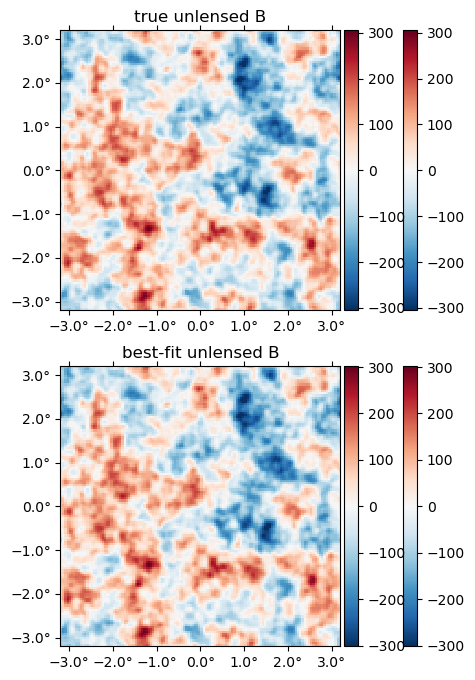

In [14]:
plot([f,fJ], title = ["true", "best-fit"] .* " unlensed " .* ["E" "B"]);

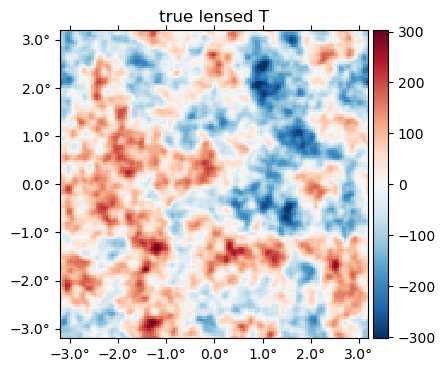

In [15]:
plot([f̃], title = ["true"] .* " lensed " .* ["T"]);

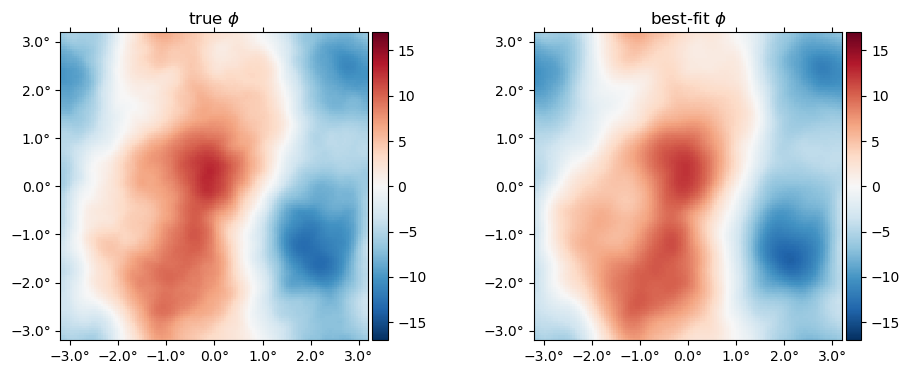

In [16]:
PythonPlot.plot(10^6*[ϕ ϕJ], title=["true" "best-fit"] .* raw" $\phi$", vlim=17);
